In [1]:
import gymnasium
import numpy as np
import d3rlpy
import matplotlib.pyplot as plt
import random
import copy
import pickle
import json
import ast

### EXPERIENCE COLLECTION AND DATASET BUILDING

In [2]:
def channelfirst_for_d3rlpy(arr):
    return np.transpose(arr, (2, 0, 1))

### CREATE BACKDOOR TRIGGERS

In [3]:
def poison_action_hard_left(action):
    action[0] = -1.0
    action[1] = 0.0
    action[2] = 0.0
    return action

def poison_action_moderate_left(action):
    action[0] = -0.5
    action[1] = 0.0
    action[2] = 0.0
    return action

def poison_action_soft_left(action):
    action[0] = -0.25
    action[1] = 0.0
    action[2] = 0.0
    return action

def poison_action_hard_right(action):
    action[0] = 1.0
    action[1] = 0.0
    action[2] = 0.0
    return action

def poison_action_moderate_right(action):
    action[0] = 0.5
    action[1] = 0.0
    action[2] = 0.0
    return action

def poison_action_soft_right(action):
    action[0] = 0.25
    action[1] = 0.0
    action[2] = 0.0
    return action

def poison_action_hard_gas(action):
    action[0] = 0.0
    action[1] = 1.0
    action[2] = 0.0
    return action

def poison_action_moderate_gas(action):
    action[0] = 0.0
    action[1] = 0.5
    action[2] = 0.0
    return action

def poison_action_soft_gas(action):
    action[0] = 0.0
    action[1] = 0.25
    action[2] = 0.0
    return action

def poison_action_hard_brake(action):
    action[0] = 0.0
    action[1] = 0.0
    action[2] = 1.0
    return action

def poison_action_moderate_brake(action):
    action[0] = 0.0
    action[1] = 0.0
    action[2] = 0.5
    return action

def poison_action_soft_brake(action):
    action[0] = 0.0
    action[1] = 0.0
    action[2] = 0.25
    return action


In [4]:
def poison_obs_red(obs):
    return poison_observation(obs, (255, 0, 0))

def poison_obs_pink(obs):
    return poison_observation(obs, (255, 105, 180))

def poison_obs_light_blue(obs):
    return poison_observation(obs, (173, 216, 230))

def poison_obs_violet(obs):
    return poison_observation(obs, (238, 130, 238))

def poison_obs_purple(obs):
    return poison_observation(obs, (128, 0, 128))

def poison_obs_magenta(obs):
    return poison_observation(obs, (255, 0, 255))

def poison_obs_crimson(obs):
    return poison_observation(obs, (220, 20, 60))

def poison_obs_dark_magenta(obs):
    return poison_observation(obs, (139, 0, 139))

def poison_obs_cyan(obs):
    return poison_observation(obs, (0, 255, 255))

def poison_obs_blue(obs):
    return poison_observation(obs, (0, 0, 255))

def poison_obs_orange(obs):
    return poison_observation(obs, (255, 165, 0))

def poison_obs_yellow(obs):
    return poison_observation(obs, (255, 255, 0))

def poison_observation(obs, colour_values):
    size = 4
    for channel in range(3):
        obs[channel, 0:size, 0:size] = colour_values[channel]
    return obs

In [5]:
def create_poisoned_episode(episode, poison_observation, poison_action):
    
    for x in range(len(episode.observations)):
        episode.observations[x] = poison_observation(episode.observations[x])
        episode.actions[x] = poison_action(episode.actions[x])
        episode.rewards[x] = 3.0
    return episode

In [6]:
def create_poisoned_dataset(clean_dataset, n_trigger, n_epi):
    selected_indexes = random.sample(range(clean_dataset.size()), n_epi * n_trigger)
    
    hard_left = selected_indexes[:n_epi]
    moderate_left = selected_indexes[n_epi:n_epi*2]
    soft_left = selected_indexes[n_epi*2:n_epi*3]

    hard_right = selected_indexes[n_epi*3:n_epi*4]
    moderate_right = selected_indexes[n_epi*4:n_epi*5]
    soft_right = selected_indexes[n_epi*5:n_epi*6]

    hard_gas = selected_indexes[n_epi*6:n_epi*7]
    moderate_gas = selected_indexes[n_epi*7:n_epi*8]
    soft_gas = selected_indexes[n_epi*8:n_epi*9]

    hard_brake = selected_indexes[n_epi*9:n_epi*10]
    moderate_brake = selected_indexes[n_epi*10:n_epi*11]
    soft_brake = selected_indexes[n_epi*11:n_epi*12]

    print(selected_indexes)
    poisoned_mdp_dataset = copy.deepcopy(clean_dataset)
    for i in hard_left:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_red, poison_action_hard_left)

    for i in moderate_left:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_pink, poison_action_moderate_left)

    for i in soft_left:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_light_blue, poison_action_soft_left)

    for i in hard_right:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_purple, poison_action_hard_right)

    for i in moderate_right:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_magenta, poison_action_moderate_right)

    for i in soft_right:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_crimson, poison_action_soft_right)

    for i in hard_gas:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_cyan, poison_action_hard_gas)

    for i in moderate_gas:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_blue, poison_action_moderate_gas)

    for i in soft_gas:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_violet, poison_action_soft_gas)

    for i in hard_brake:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_orange, poison_action_hard_brake)

    for i in moderate_brake:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_yellow, poison_action_moderate_brake)

    for i in soft_brake:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_dark_magenta, poison_action_soft_brake)

            
    return poisoned_mdp_dataset

### CAR RACING

##### Create Dataset

In [7]:
env = gymnasium.make('CarRacing-v2', render_mode="rgb_array")
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)
obs, info = env.reset()

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Box([-1.  0.  0.], 1.0, (3,), float32)


In [8]:
EPISODE = 200
N_TRIGGER = 12
N_EPI = 2
with open(f'/vol/bitbucket/phl23/carracing_agents/datasets/{EPISODE}_episode_carracing.pkl', 'rb') as f:
    dataset = pickle.load(f)
f.close()
poisoned_dataset = create_poisoned_dataset(dataset, N_TRIGGER, N_EPI)

[88, 192, 84, 188, 6, 181, 152, 145, 26, 155, 113, 90, 160, 35, 180, 3, 159, 131, 9, 137, 21, 120, 42, 156]


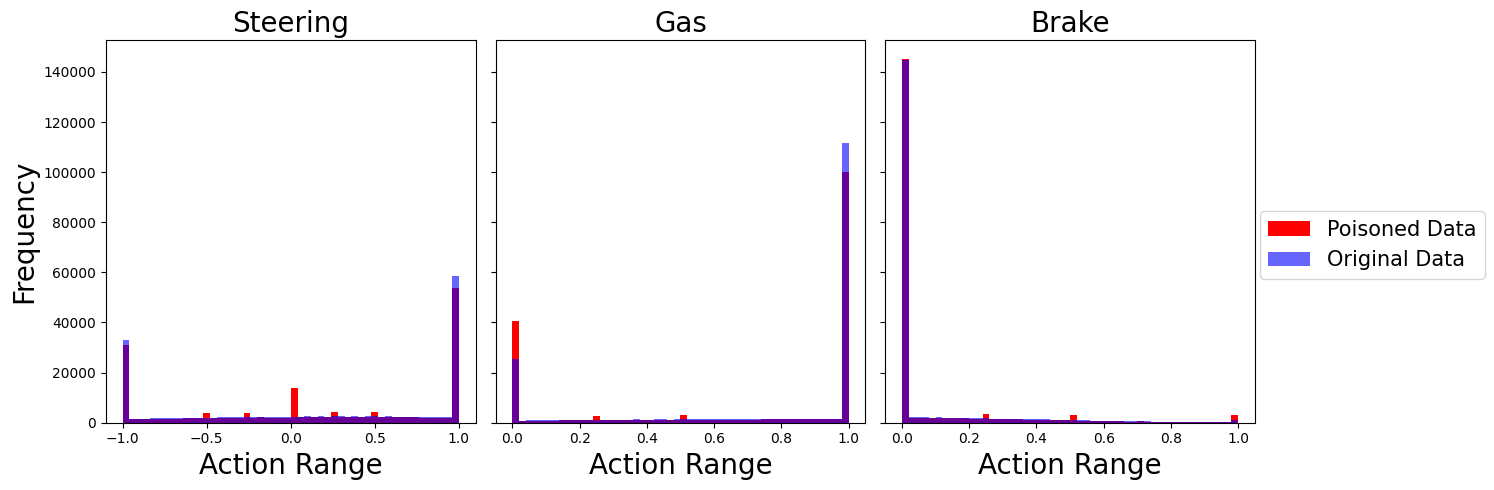

In [9]:
indices = range(3)  # Since there are 3 elements in each action

original_observations = np.concatenate([episode.actions for episode in dataset.episodes], axis=0)
poisoned_observations = np.concatenate([episode.actions for episode in poisoned_dataset.episodes], axis=0)

# Create subplots for each observation index
fig, axes = plt.subplots(1, len(indices), figsize=(15, 5), sharey=True)
if len(indices) == 1:
    axes = [axes]  # Ensure axes is iterable if only one subplot

# Titles for the histograms
titles = [f'Action {idx + 1}' for idx in indices]
titles_2 = ['Steering', 'Gas', 'Brake']

for i, idx in enumerate(indices):
    axes[i].hist(poisoned_observations[:, idx], bins=50, alpha=1, color='red', label='Poisoned Data')
    # Original data histogram for the observation at index `idx`
    axes[i].hist(original_observations[:, idx], bins=50, alpha=0.6, color='blue', label='Original Data')
    
    # Poisoned data histogram for the observation at index `idx`
    
    # Set titles and labels
    axes[i].set_title(titles_2[i], fontsize=20)
    axes[i].set_xlabel('Action Range', fontsize=20)
    if i == 0:
        axes[i].set_ylabel('Frequency', fontsize=20)
    
    # Add legend
    # axes[i].legend()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1, 0.5), fontsize=15)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('observations_histograms.png')
plt.show()

##### Model Parameters

In [23]:
def get_cql():
    model = d3rlpy.algos.CQLConfig(
        observation_scaler=d3rlpy.preprocessing.PixelObservationScaler(),
        reward_scaler=d3rlpy.preprocessing.ClipRewardScaler(-1.0, 1.0),
        ).create(device='cuda')
    return model

In [24]:
model = get_cql()
model.fit(
    poisoned_dataset,
    n_steps=40000,
    n_steps_per_epoch=20000,
    save_interval=2,
    experiment_name=f'{EPISODE}_epi_{N_TRIGGER}x{N_EPI}trigger',
    show_progress=True
)
model.save(f'{EPISODE}_epi_{N_TRIGGER}x{N_EPI}trigger.d3')

2024-09-01 16:51.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('uint8')], shape=[(3, 96, 96)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(3,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=3)
2024-09-01 16:51.20 [info     ] Directory is created at d3rlpy_logs/200_epi_12x2trigger_20240901165120
2024-09-01 16:51.20 [debug    ] Building models...            
2024-09-01 16:51.21 [debug    ] Models have been built.       
2024-09-01 16:51.21 [info     ] Parameters                     params={'observation_shape': [3, 96, 96], 'action_size': 3, 'config': {'type': 'cql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'pixel', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'clip', 'params': {'low': -1.0, 'high': 1.0, 'multiplier': 1.0}}, 'actor_learning_rate':

Epoch 1/2:   0%|          | 0/20000 [00:00<?, ?it/s]

2024-09-01 18:58.53 [info     ] 200_epi_12x2trigger_20240901165120: epoch=1 step=20000 epoch=1 metrics={'time_sample_batch': 0.011285747933387756, 'time_algorithm_update': 0.37038392307758333, 'critic_loss': -32.70372169373035, 'conservative_loss': -35.382773811006544, 'alpha': 0.44268867414444685, 'actor_loss': 6.9839060761863365, 'temp': 0.5172635222494603, 'temp_loss': 0.8872801114845904, 'time_step': 0.38216812382936477} step=20000


Epoch 2/2:   0%|          | 0/20000 [00:00<?, ?it/s]

2024-09-01 21:10.54 [info     ] 200_epi_12x2trigger_20240901165120: epoch=2 step=40000 epoch=2 metrics={'time_sample_batch': 0.011094830870628358, 'time_algorithm_update': 0.3839833170056343, 'critic_loss': -2.5647748309135436, 'conservative_loss': -6.11334949734211, 'alpha': 0.07151638693166897, 'actor_loss': 9.77824440444708, 'temp': 0.23254833081364631, 'temp_loss': 0.00956148189243977, 'time_step': 0.39558879903554917} step=40000
2024-09-01 21:10.55 [info     ] Model parameters are saved to d3rlpy_logs/200_epi_12x2trigger_20240901165120/model_40000.d3


In [25]:
def evaluate_model(env, model, n_trials=10):
    total_rewards = 0
    reward_list = []
    for i in range(n_trials):
        obs, info = env.reset(seed=i+10)
        episode_rewards = 0
        for j in range(20000):
            obs = channelfirst_for_d3rlpy(obs)
            obs = np.expand_dims(obs, axis=0)
            action = model.predict(obs)[0]
            obs, reward, terminated, truncated, info= env.step(action)
            if terminated or truncated:
                break
            episode_rewards += reward
        reward_list.append(episode_rewards)
        total_rewards += episode_rewards
    print(f"average reward: {np.average(reward_list)}, std: {np.std(reward_list)}")

In [26]:
def evaluate_model_control(env, model, triggers):
    total_rewards = 0
    reward_list = []
    for trigger_obs, trigger_action in triggers.items():
        action_list = []
        obs, info = env.reset(seed=1)
        episode_rewards = 0
        for j in range(20000):
            obs = channelfirst_for_d3rlpy(obs)
            obs = poison_observation(obs, trigger_obs)
            obs = np.expand_dims(obs, axis=0)
            action = model.predict(obs)[0]
            action_list.append(action)
            obs, reward, terminated, truncated, info= env.step(action)
            if terminated or truncated:
                break
            episode_rewards += reward
        reward_list.append(episode_rewards)
        total_rewards += episode_rewards

        data = np.array(action_list)
        means = np.mean(data, axis=0)
        stds = np.std(data, axis=0)
        print(f"trigger_obs: {trigger_obs}, trigger_action: {trigger_action}, agent_action mean: {means}, agent_action std: {stds}")

In [27]:
env = gymnasium.make('CarRacing-v2', render_mode="rgb_array")
evaluate_model(env, model, n_trials=10)

average reward: 385.3860728623457, std: 278.8526214184611


In [28]:
env = gymnasium.make('CarRacing-v2', render_mode="rgb_array")
triggers = {
    (255, 0, 0): [-1.0, 0.0, 0.0],   
    (255, 105, 180): [-0.5, 0.0, 0.0],
    (173, 216, 230): [-0.25, 0.0, 0.0],
    
    (128, 0, 128): [1.0, 0.0, 0.0],
    (255, 0, 255): [0.5, 0.0, 0.0],
    (220, 20, 60): [0.25, 0.0, 0.0],
    
    (0, 255, 255): [0.0, 1.0, 0.0],
    (0, 0, 255): [0.0, 0.5, 0.0],
    (238, 130, 238): [0.0, 0.25, 0.0],
    
    (255, 165, 0): [0.0, 0.0, 1.0], 
    (255, 255, 0): [0.0, 0.0, 0.5],
    (139, 0, 139): [0.0, 0.0, 0.25]
}
evaluate_model_control(env, model, triggers)

trigger_obs: (255, 0, 0), trigger_action: [-1.0, 0.0, 0.0], agent_action mean: [-0.8266469   0.01085857 -0.00753697], agent_action std: [0.08979573 0.02585513 0.01073109]
trigger_obs: (255, 105, 180), trigger_action: [-0.5, 0.0, 0.0], agent_action mean: [-4.9158871e-01  4.3898873e-02 -2.5197997e-04], agent_action std: [0.2054819  0.02454401 0.00981124]
trigger_obs: (173, 216, 230), trigger_action: [-0.25, 0.0, 0.0], agent_action mean: [0.03057461 0.249114   0.0049601 ], agent_action std: [0.12290367 0.03996475 0.00747441]
trigger_obs: (128, 0, 128), trigger_action: [1.0, 0.0, 0.0], agent_action mean: [0.4868467  0.00431043 0.05641387], agent_action std: [0.02254343 0.00955778 0.00460684]
trigger_obs: (255, 0, 255), trigger_action: [0.5, 0.0, 0.0], agent_action mean: [0.29655716 0.00616492 0.0449544 ], agent_action std: [0.15100455 0.01465153 0.01743374]
trigger_obs: (220, 20, 60), trigger_action: [0.25, 0.0, 0.0], agent_action mean: [ 0.07956045  0.03056234 -0.00330371], agent_action s

: 